# Universidad de Buenos Aires
# TP FINAL-COMPUTER VISION 2
# Alumnos: Matias Werbin y Noelia Qualindi

In [1]:
# importación de librerias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import cv2
import matplotlib.pyplot as plt


In [2]:
import zipfile
import os

# Ruta al archivo zip y al directorio de destino
zip_file_path = "Brain-Tumor-Classification-DataSet-master.zip"
extract_to = "Brain-Tumor-Classification-DataSet-master"

# Descomprimir el archivo
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verifica que los archivos se han extraído
print("Archivos extraídos:")
print(os.listdir(extract_to))


Archivos extraídos:
['Brain-Tumor-Classification-DataSet-master']


In [3]:
# rutas
TEST_PATH = 'Brain-Tumor-Classification-DataSet-master\Brain-Tumor-Classification-DataSet-master\Testing'
TRAIN_PATH = 'Brain-Tumor-Classification-DataSet-master\Brain-Tumor-Classification-DataSet-master\Training'
# tamaño de imagen
IMG_SIZE = 224
#  categorias
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

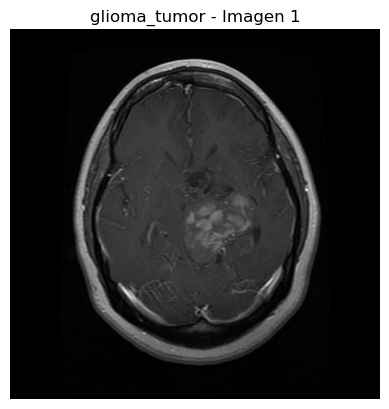

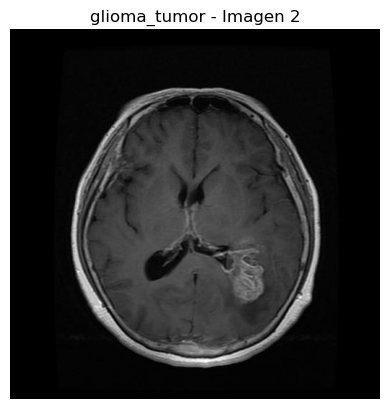

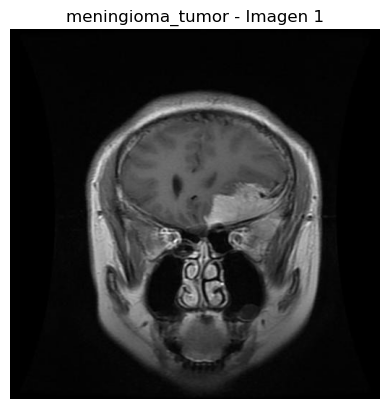

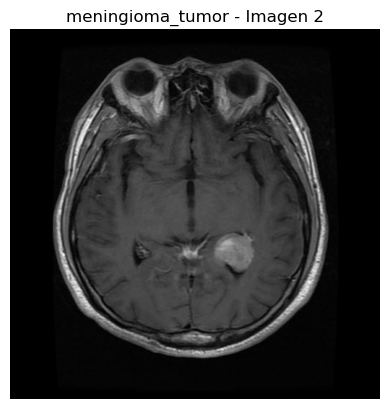

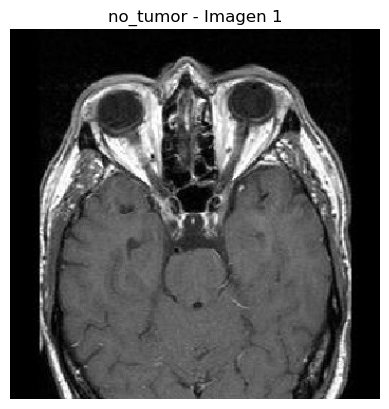

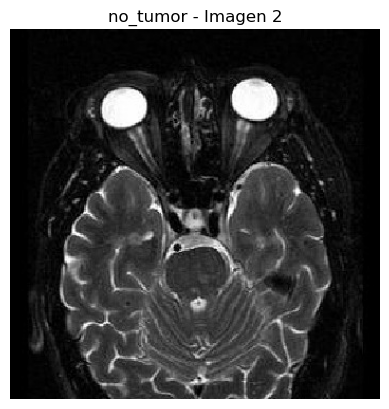

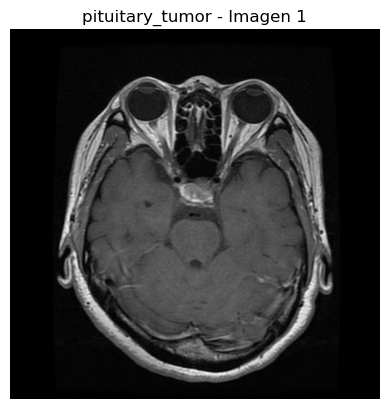

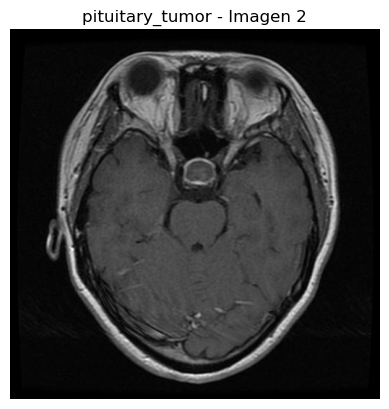

In [4]:
for category in CATEGORIES:
  image_files=os.listdir(os.path.join(TRAIN_PATH,category))
  if len(image_files)>=2:
    for i in range(2):
      image_path=os.path.join(TRAIN_PATH,category,image_files[i])
      image=cv2.imread(image_path)

      plt.imshow(image)
      plt.title(f"{category} - Imagen {i+1}")
      plt.axis('off')
      plt.show()




In [5]:
# Preparación de data train

train_data=[]

def create_train():
  """ Funcion para generar dataset de train con array de imagenes y etiquetas"""
  for category in CATEGORIES:
    path=os.path.join(TRAIN_PATH,category)
    classes=CATEGORIES.index(category)
    for img in tqdm(os.listdir(path)):
      img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
      resized_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      train_data.append([resized_array,classes])

  random.shuffle(train_data)
  return train_data

train_dataset=create_train()

X_train = np.array([item[0] for item in train_dataset]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_train = np.array([item[1] for item in train_dataset])




100%|██████████| 827/827 [00:08<00:00, 97.44it/s] 


In [7]:
# Cantidad de imagenes de entrenamiento
len(X_train)

2870

In [8]:
# Cantidad de etiquetas de entrenamiento
len(y_train)

2870

In [9]:
label, frecuencias = np.unique(y_train, return_counts=True)

for label, frecuencia in zip(label, frecuencias):
    print(f"Label: {label}, Frecuencia: {frecuencia}")

Label: 0, Frecuencia: 826
Label: 1, Frecuencia: 822
Label: 2, Frecuencia: 395
Label: 3, Frecuencia: 827


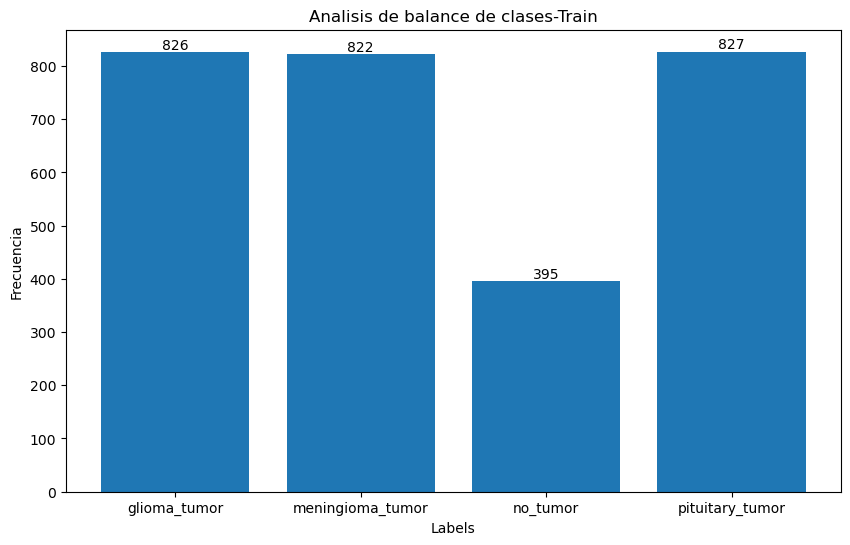

In [10]:
plt.figure(figsize=(10,6))
plt.bar(CATEGORIES, frecuencias)

for i, freq in enumerate(frecuencias):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

plt.xlabel('Labels')
plt.ylabel('Frecuencia')
plt.title("Analisis de balance de clases-Train")
plt.show()


Podemos observar que se presenta un desbalance de clase. En este caso, la clase minororitaria es no_tumor. Esto a priori no deberia presentar un problema porque nos interesa que la red pueda aprender a clasificar las imagenes que son tumores de las que no. De igual manera, tambien es muy importante poder predecir correctamente las que no son pero en este tipo de problemas es mas critico el TP de las clases asociadas a tumores.

In [11]:
idx2category = {i: category for i, category in enumerate(CATEGORIES)}
idx2category

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

In [12]:
category2idx = {category: i for i, category in enumerate(CATEGORIES)}
category2idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

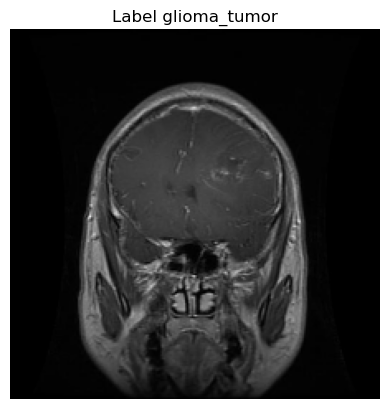

In [13]:
# Visualizar la primera imagen
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label {idx2category.get(y_train[0],-1)}")
plt.axis('off')
plt.show()

In [14]:
test_data=[]

def create_test():
  """ Funcion para generar dataset de test con array de imagenes y etiquetas"""
  for category in CATEGORIES:
    path=os.path.join(TEST_PATH,category)
    classes=CATEGORIES.index(category)
    for img in tqdm(os.listdir(path)):
      img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
      resized_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      test_data.append([resized_array,classes])

  random.shuffle(test_data)
  return test_data

test_dataset=create_test()

X_test = np.array([item[0] for item in test_dataset]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_test = np.array([item[1] for item in test_dataset])


100%|██████████| 74/74 [00:00<00:00, 76.52it/s]


In [15]:
# Cantidad de imagenes de testeo
len(X_test)

394

In [16]:
# Cantidad de etiquetas de testeo
len(y_test)

394

Label: 0, Frecuencia: 100
Label: 1, Frecuencia: 115
Label: 2, Frecuencia: 105
Label: 3, Frecuencia: 74



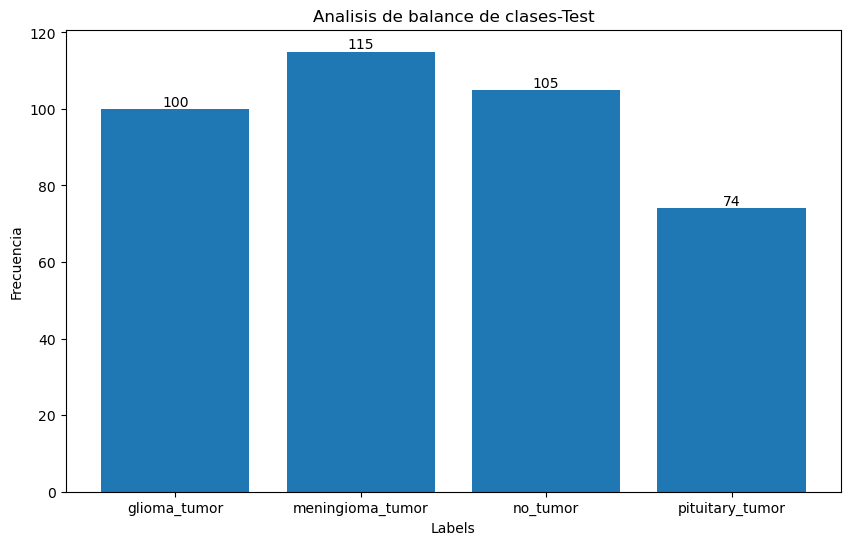

In [17]:
label, frecuencias = np.unique(y_test, return_counts=True)

for label, frecuencia in zip(label, frecuencias):
    print(f"Label: {label}, Frecuencia: {frecuencia}")

print("")

plt.figure(figsize=(10,6))

plt.bar(CATEGORIES,frecuencias)

for i, freq in enumerate(frecuencias):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

plt.xlabel("Labels")
plt.ylabel("Frecuencia")
plt.title("Analisis de balance de clases-Test")
plt.show()




Podemos observar que el set de testeo se encuentra bastante balanceado por lo que podemos usar el accuracy como metrica de validación.

In [18]:
# Normalización de X_train y X_test

from tensorflow.keras.applications.vgg16 import preprocess_input

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Armamos sets de validación

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid=train_test_split(X_train,y_train, test_size=0.25, random_state=74,stratify=y_train)


In [18]:
print(f"Shape X_train{X_train.shape}")
print(f"Shape X_valid{X_valid.shape}")
print(f"Shape X_test{X_test.shape}")
print(f"Shape y_train{y_train.shape}")
print(f"Shape y_valid{y_valid.shape}")
print(f"Shape y_test{y_test.shape}")

Shape X_train(2152, 224, 224, 3)
Shape X_valid(718, 224, 224, 3)
Shape X_test(394, 224, 224, 3)
Shape y_train(2152,)
Shape y_valid(718,)
Shape y_test(394,)


In [33]:
# Carga de VGG16 sin cabezal de clasificación

vgg16_model=VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Haremos transfer learning (feature extration) eliminando la capa densa de clasificación y adaptandola a nuestro problema.

In [34]:
# Cargamos layers a modelo
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# Congelamos las capas de VGG16
for layer in model.layers:
    layer.trainable = False
# Incorporamos cabeza de clasificación de 4 clases
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [35]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint

def create_callbacks(model_name):
    # Callback para imprimir la pérdida y la métrica en cada época
    print_epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"Epoch {epoch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs.get('accuracy', 'N/A'):.4f}, "
            f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs.get('val_accuracy', 'N/A'):.4f}"
        )
    )

    # Callback de EarlyStopping para monitorear la métrica de validación
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

    #  Callback de ModelCheckpoint para guardar el mejor modelo
    mc = ModelCheckpoint(f'Models/{model_name}_best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

    return [print_epoch_callback, es, mc]



In [37]:
model_name='vgg16_tl_noaug_es'

callbacks=create_callbacks(model_name)

In [38]:
history_vgg16_noaug = model.fit(
    X_train, y_train,
    validation_data=[X_valid, y_valid],
    batch_size=32,
    epochs=50,
    callbacks=callbacks
)

Train on 2152 samples, validate on 718 samples
Epoch 1/50
2144/2152 [============================>.] - ETA: 0s - loss: 5.5514 - accuracy: 0.7472Epoch 1: Loss: 5.5307, Accuracy: 0.7481, Val Loss: 2.2968, Val Accuracy: 0.8816

Epoch 00001: val_accuracy improved from -inf to 0.88162, saving model to Models/vgg16_tl_noaug_es_best_model.h5
2152/2152 [==============================] - 35s 16ms/sample - loss: 5.5307 - accuracy: 0.7481 - val_loss: 2.2968 - val_accuracy: 0.8816
Epoch 2/50
2144/2152 [============================>.] - ETA: 0s - loss: 0.7384 - accuracy: 0.9436Epoch 2: Loss: 0.7357, Accuracy: 0.9438, Val Loss: 2.0195, Val Accuracy: 0.8914

Epoch 00002: val_accuracy improved from 0.88162 to 0.89136, saving model to Models/vgg16_tl_noaug_es_best_model.h5
2152/2152 [==============================] - 34s 16ms/sample - loss: 0.7357 - accuracy: 0.9438 - val_loss: 2.0195 - val_accuracy: 0.8914
Epoch 3/50
2144/2152 [============================>.] - ETA: 0s - loss: 0.4077 - accuracy: 0.971

In [39]:
history_save_path = 'Models/history_vgg16_tl_noaug_es.pkl'
weights_save_path="Models/weights_vgg16_tl_noaug_es.h5"


# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_vgg16_noaug.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en Models/history_vgg16_tl_noaug_es.pkl
Pesos guardado en Models/weights_vgg16_tl_noaug_es.h5


In [27]:
train_loss=history_vgg16_noaug.history['loss']
train_acc=history_vgg16_noaug.history['accuracy']
val_loss=history_vgg16_noaug.history['val_loss']
val_acc=history_vgg16_noaug.history['val_accuracy']


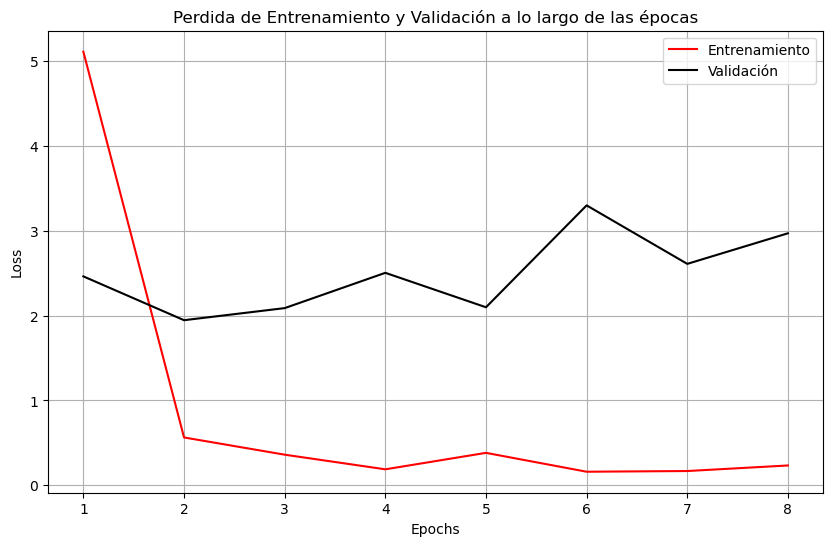

In [40]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

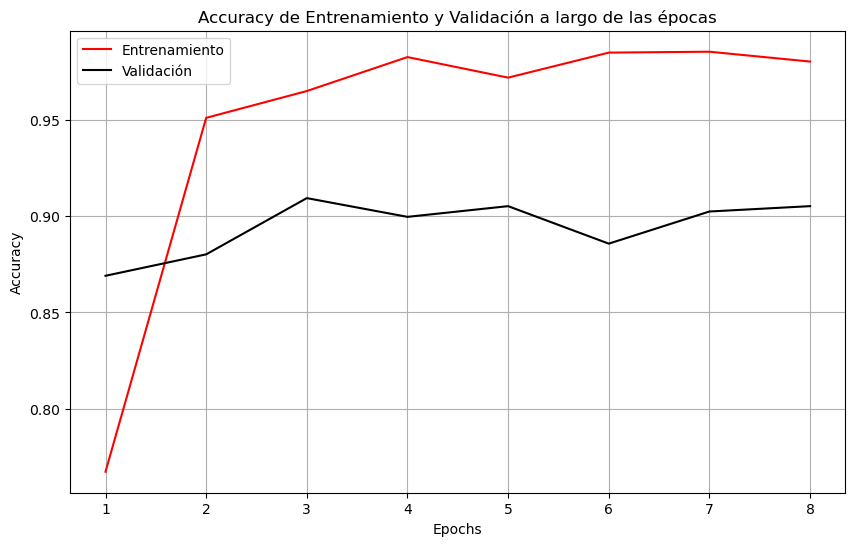

In [41]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()


El modelo paró por Eearly Stopping y podemos ver en las curvas de loss que todavia tienen potencial para seguir disminuyendo los valores de pérdida como tambien un claro overfitting en la visualizaciones de de accuracy. Vamos a dejar el modelo correr por 20 epocas y ver que ocurre. Para eso debemos volver a inicializarlos para que los pesos anteriores no afecten al mismo.

In [42]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
# Definimos unicamente los callbacks a ejecutar

print_epoch_callback = LambdaCallback(
  on_epoch_end=lambda epoch, logs: print(
    f"Epoch {epoch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs.get('accuracy', 'N/A'):.4f}, "
    f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs.get('val_accuracy', 'N/A'):.4f}"
  )
)


mc = ModelCheckpoint(f'Models/{model_name}_best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [46]:
model_name='vgg16_tl_noaug_20'

In [47]:


history_vgg16_noaug_20=model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=[X_valid, y_valid],
    callbacks=[print_epoch_callback,mc]
    )

Train on 2152 samples, validate on 718 samples
Epoch 1/20
2144/2152 [============================>.] - ETA: 0s - loss: 4.7011 - accuracy: 0.7687Epoch 1: Loss: 4.6923, Accuracy: 0.7691, Val Loss: 3.2171, Val Accuracy: 0.8538

Epoch 00001: val_accuracy improved from -inf to 0.85376, saving model to Models/vgg16_tl_noaug_20_best_model.h5
2152/2152 [==============================] - 35s 16ms/sample - loss: 4.6923 - accuracy: 0.7691 - val_loss: 3.2171 - val_accuracy: 0.8538
Epoch 2/20
2144/2152 [============================>.] - ETA: 0s - loss: 0.7630 - accuracy: 0.9422Epoch 2: Loss: 0.7602, Accuracy: 0.9424, Val Loss: 2.3493, Val Accuracy: 0.8914

Epoch 00002: val_accuracy improved from 0.85376 to 0.89136, saving model to Models/vgg16_tl_noaug_20_best_model.h5
2152/2152 [==============================] - 34s 16ms/sample - loss: 0.7602 - accuracy: 0.9424 - val_loss: 2.3493 - val_accuracy: 0.8914
Epoch 3/20
2144/2152 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.969

In [48]:
history_save_path = 'Models/history_vgg16_tl_noaug_20.pkl'
weights_save_path="Models/weights_vgg16_tl_noaug_20.h5"


# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_vgg16_noaug.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en Models/history_vgg16_tl_noaug_20.pkl
Pesos guardado en Models/weights_vgg16_tl_noaug_20.h5


In [49]:
train_loss=history_vgg16_noaug_20.history['loss']
train_acc=history_vgg16_noaug_20.history['accuracy']
val_loss=history_vgg16_noaug_20.history['val_loss']
val_acc=history_vgg16_noaug_20.history['val_accuracy']

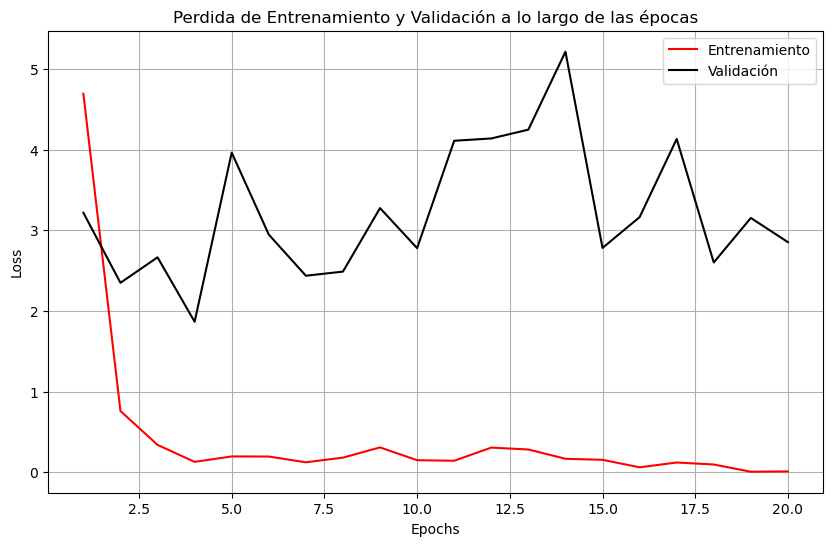

In [50]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

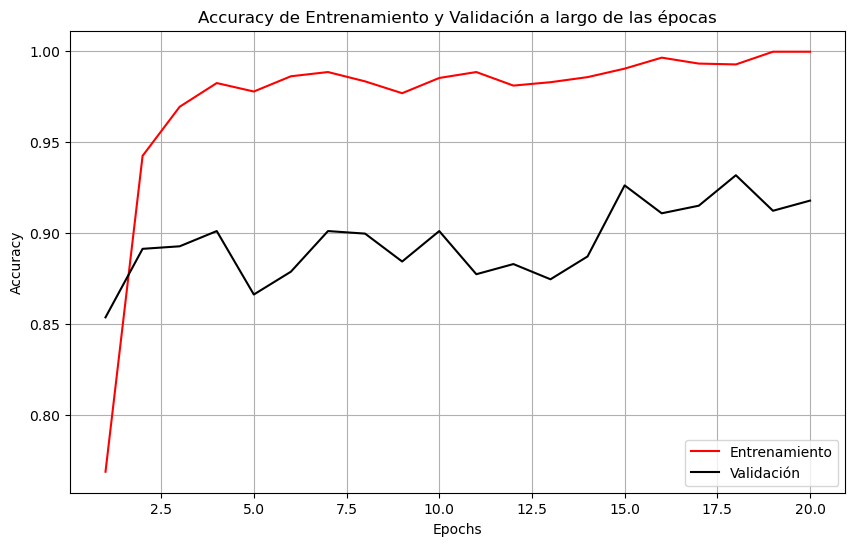

In [51]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()